# Image Denoising with Denoising AutoEncoders

In [1]:
from keras.datasets import fashion_mnist

%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

### Data Pre-processing
We need to augment our input image in order to deliberately make noises in the images. 

In [0]:
# Using salt and Pepper

from imgaug import augmenters as iaa
seq = iaa.Sequential([iaa.SaltAndPepper(0.2)])

train_x_aug = seq.augment_images(train_x)
val_x_aug = seq.augment_images(val_x)

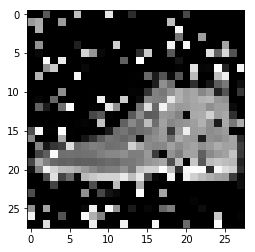

In [14]:
# normalization

train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

train_x_aug = train_x_aug/255.
val_x_aug = val_x_aug/255.

train_x_aug = train_x_aug.reshape(-1, 28, 28, 1)
val_x_aug = val_x_aug.reshape(-1, 28, 28, 1)

plt.imshow(val_x_aug[0].reshape(28, 28), cmap='gray')

### Model

In [0]:
input_img = Input(shape=(28, 28, 1))

# "encoded" is the encoded representation of the input
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPool2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

In [0]:
# "decoded" is the lossy reconstruction of the input
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), padding='same')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [0]:
encoder = Model(input_img, encoded)

In [0]:
autoencoder.compile(optimizer='adam', 
                    loss='mse'
                   )

In [0]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      min_delta=0, 
                                      patience=10, 
                                      verbose=1, 
                                      mode='auto')

In [11]:
train_history = autoencoder.fit(train_x_aug, 
                                train_x, 
                                epochs=500,
                                batch_size=2048, 
                                validation_data=(val_x_aug, val_x), 
                                callbacks=[estop])

W0819 15:56:52.911242 140026007234432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0819 15:56:53.123468 140026007234432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 13s 214us/step - loss: 0.0946 - val_loss: 0.0512
Epoch 2/500
60000/60000 [==============================] - 7s 119us/step - loss: 0.0419 - val_loss: 0.0353
Epoch 3/500
60000/60000 [==============================] - 7s 119us/step - loss: 0.0318 - val_loss: 0.0282
Epoch 4/500
60000/60000 [==============================] - 7s 120us/step - loss: 0.0263 - val_loss: 0.0255
Epoch 5/500
60000/60000 [==============================] - 7s 120us/step - loss: 0.0237 - val_loss: 0.0227
Epoch 6/500
60000/60000 [==============================] - 7s 121us/step - loss: 0.0221 - val_loss: 0.0217
Epoch 7/500
60000/60000 [==============================] - 7s 121us/step - loss: 0.0214 - val_loss: 0.0208
Epoch 8/500
60000/60000 [==============================] - 7s 121us/step - loss: 0.0205 - val_loss: 0.0202
Epoch 9/500
60000/60000 [==============================] - 7s 121us/step - loss: 0.0200 - val

In [0]:
pred = autoencoder.predict(val_x)

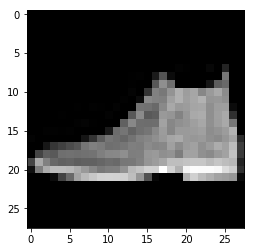

In [13]:
plt.imshow(val_x[0].reshape(28, 28), 
           cmap='gray')

This is what we get after noise removal

### Predict

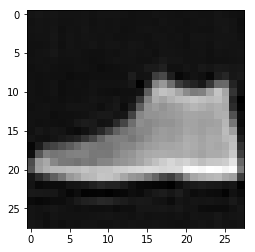

In [15]:
plt.imshow(pred[0].reshape(28, 28), cmap='gray')